# Computer Assignment (CA) No. 9: Signal To Noise Ratio and Filtering

## Problem Statement

The assignments will now start to get a little more vague and integrate concepts. For example, in this assignment you must connect the concepts of signal power and variance.
The tasks to be accomplished are:
1. Create a function that generates a signal that consists of a sinewave plus Gaussian white noise:
sig = generate_sine(frequency_in_Hz, duration_in_secs, sample_frequency_in_Hz, snr_db)
Assume the sinewave has an amplitude of +/- 1.0. What is its power? Generate a Gaussian white noise signal such that the signal to noise ratio of the summed signal is “snr_db” measured in dB (e.g., 20log10(signal_energy/noise_energy).
2. For SNRs in the range [-30 db, +30 dB] in steps of 10 dB, compute and plot the first 16 lags of the autocorrelation function for a 500 Hz sinewave sampled at 8000 Hz.
3. At what SNR does the autocorrelation start to be measurably impacted by the additive noise? 
4. For SNRs of -30 dB and +30 dB, compute a 8192 point FFT and plot the magnitude spectrum from [0, 4000 Hz]. Explain any differences you observe between the two plots.
5. Process the signal corresponding to a 30 dB SNR through a digital filter of the form:

\begin{equation} 
y[n] = 0.5y[n-1]+x[n] 
\end{equation} 

Compute the autocorrelation signal for y[n], and plot the magnitude spectrum of the Fourier Transform of the autocorrelation function. Similarly plot the square of the magnitude spectrum of the original signal, y[n]. Plot these on the same scale and compare/contrast these plots. What did you learn from this? Explain any similarities you observe. How does this plot compare to that obtained in (4). Can you explain the differences in terms of the frequency response of the linear system used to filter the signal?

In [1]:
%pylab inline
import numpy as np 
from scipy.stats import norm
plt.style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


## Approach and Results

### Task 1
Generation of sine wave with a specific signal to noise ratio was rooted in the equation below, where $E_S$ and 
$E_N$ equates to the energy of the signal and noise.

$$ SNR_{dB} = 20\log_{10}(\frac{E_S}{E_N}) = 10\log_{10}(\frac{A_S}{A_N}) $$

The energy for a continous-time signal $x(t)$ is defined as,

$$ E_S = \int_{-\infty}^{\infty} |x(t)^2| dt $$

which, luckily, due to the wide-sense stationary (WSS) nature of a sine wave, is equal to the variance of the signal $\sigma_s^2 $. This is also true for the energy of gaussian white noise $E_N = \sigma_N^2$, as the mean of the noise is zero. If a constant is introduced to the equation for energy to scale the amplitude of the signal to increase the energy, it would simplifly to the following: 
$$E_x = \int_{-\infty}^{\infty} |(ax(t))^2| dt = a^2\int_{-\infty}^{\infty} |x(t)^2| = a^2\sigma_x^2 dt $$

As the constant can be factored out of the integral, an expression can be formulated using the SNR equation for a scaler which would reduce or increase $E_N$ for a requested SNR. If our final signal is $y = x + ae$, with $c = a^2$ acting as our scaler, 
$$SNR_{dB} = 20\log_{10}(\frac{E_S}{E_N}) = 20\log_{10}(\frac{\sigma_S^2}{c\sigma_N^2}).$$
Therefore, 
$$ c = \frac{\sigma^2_S}{\sigma_N^2 10^{SNR/20}} $$ 
$$ a = \sqrt(\frac{\sigma^2_S}{\sigma_N^2 10^{SNR/20}}) = \frac{\sigma_S}{\sigma_N \sqrt{10^{SNR/20}}}$$.

Utilizing the expression for the scaler above, the generate_sine function was written as can be seen below. Adjusting the SNR parameter can be seen to introduce additional noise. The function also prints the SNR if the commented line is removed. 



In [2]:
def generate_sine(freq, duration, fs, snr): 
# freq: pure signal frequancy of duration with sample rate fs 
# and signal to noise ratio snr in dB.
    samples = fs*duration  # number of samples is equal to the samples per second * the number of seconds
    t = np.linspace(0, duration, samples)  # generate time vector 
    freq_radians = (2*np.pi)*freq
    x = np.sin(freq_radians*t)  # generate signal 
    e = norm.rvs(size=samples)
    c = sqrt(np.var(x)/(np.var(e)*10**(snr/20)))
    #print 20*log(var(x)/var(c*e))/log(10)

    return x + c*e

# TESTING
#SNR = 30
#x = generate_sine(10, 0.2, 1000, SNR)
#plot(x)

### Task 2 & 3

An autocorrelation function was first written utilizing the definition below, 
$$ R_{yy}(l) = \sum y(n)y(n-l)$$


In [3]:
def autocorr(x, M): 
    '''
        Autocorrlates signal X with a delay of M samples.
        Returns $R_{xx}(t, t-\tau). The function autocorrlated in indexed past the lag point. 
    '''
    Ryy = zeros(M+1) 
    for tau in range(M+1): 
        #print x[M:]
        #print x[M-tau:-tau]
        Ryy[tau] = sum( x[M:]*x[M-tau:len(x)-tau] )
    return Ryy
#TESTING 
#noise = [-30, -20, -10, 0, 10, 20, 30]
#for n in noise:
#    x = generate_sine(500, 0.2, 8000, n)
#    print n, autocorr(x, 16)

A list was then generated containing the requested SNR values. The list was step through, and at each iteration a signal of the specific SNR was generated and the autocorrelation plotted. This can be seen in the plots below. 

From the plots it can be noted that at a SNR of 0dB or greater a sine function appears as a complete cycle in the 16 lags. The signal requested was a sine wave of 500 Hz with a sampling frequency of 8 kHz. This would result in $\frac{8000}{500} = 16$ samples per cycle. The autocorrelation function appears to filter out a portion of the gaussian noise, and leave the original signal intact. If $x$ representes the sine wave, $a$ is a scaler, and $n$ is white noise, the output signal can be represented again in the following form:

$$ y = x + a\times n .$$ 
The autocorrelation of the signal would be equal to 

$$ R_{yy}(\tau) = R_{xx}(\tau) + aR_{xn}(\tau) + aR_{nx}(\tau) + a^2R_{nn}(\tau),$$ 

but as $x(t)$ and $n(t)$ are independent their crosscorrelation ($R_{xn}$ and $R_{nx}$) is equal to a product of their means which is equal to zero reducing the autocorrelation sum to 

$$ R_{yy}(\tau) = R_{xx}(\tau) + a^2R_{nn}(\tau). $$

Luckily, the autocorrelation of white noise is zero except when the lag value is equal to zero; thus, $R_{nn}(\tau) = R_{nn}(\tau)\delta(\tau)$ which simplies to $\sigma_n^2\delta(\tau)$ as the $E[n(t)] = 0$. This results in the final expression for the autocorrelation for output signal with a specific SNR 

$$ R_{yy}(\tau) = R_{xx}(\tau) + a^2\sigma_N^2 \delta(\tau). $$ 

It is understandable that the autocorrelation of $y(t)$ should therefore include a noise spike at a lag of 0, but it is still unclear why the signals with a SNR of less than 0dB appear destroyed. Shouldn't they still exist? For a closer look, I altered the autocorrelation plot abscissa to ignore when $\tau = 0$ to avoid autoscaling any waveform. A waveform is now distinguishable at a SNR of -20dB. Noise is indistinguishable at 0dB. 

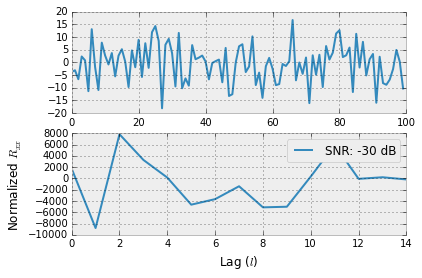

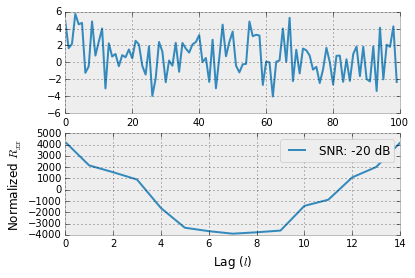

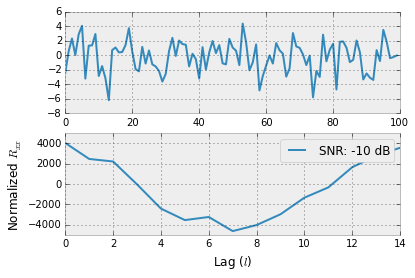

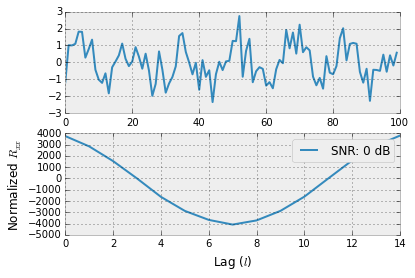

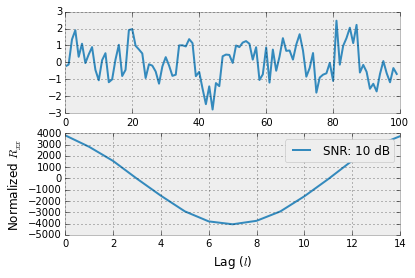

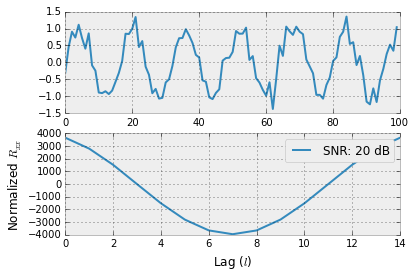

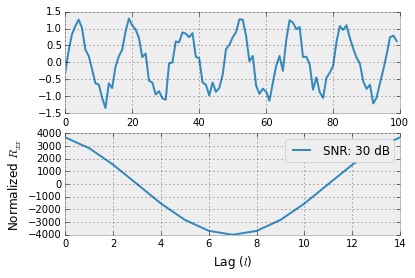

In [4]:

noise = [-30, -20, -10, 0, 10, 20, 30] # dB vector for noise 
L = 16
for n in noise: 
    x = generate_sine(500, 1, 8000, n)
    R = autocorr(x, L)
    fig = figure()
    ax1 = fig.add_subplot(212)
    ax2 = fig.add_subplot(211) 
    ax2.plot(x[0:100])
    ax1.plot(R[1:16], label="SNR: %d dB" %n) 
    ax1.set_xlabel(r'Lag ($l$)')
    ax1.set_ylabel(r'Normalized $R_{xx}$')
    ax1.legend()

### Task 4 

The fourier transform of a signal with a -30 SNR and 30 SNR is displayed in the top and bottom subplot, respectively, of the figure below. The magnitude of the fourier transform is logarithmic. The fourier transform of the signal with a -30dB SNR displays power across the entire retrievable spectrum of the sampling frequency. This is due to the dominance of the noise in the signal. An impulse is visiable at 500 Hz still. The bottom subplot displaying the 30dB SNR signal contains an impulse at 500Hz and random noise along the floor of the fourier transform. This is due to the sine signal's dominance. 


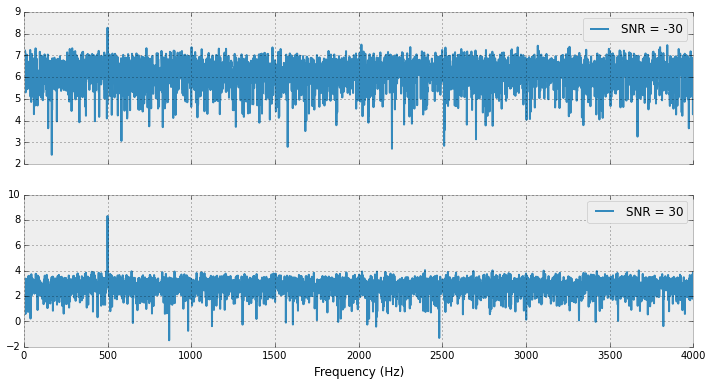

In [5]:
F = 800
L = 3 
Fs = 8000
N = 8192
SNRs = [-30, 30] 
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
for SNR, ax in zip(SNRs, axes):
    x = generate_sine(500, 2, 8000, SNR) 
    FFTsig = fft.rfft(x, n=N)
    FFTfreq = fft.rfftfreq(N, d=1./Fs)
    ax.plot(FFTfreq, log(abs(FFTsig)), label='SNR = ' + str(SNR))
    ax.legend()
ax.set_xlabel('Frequency (Hz)')

### Task 5
The output of the digital filter: $ y[n]=0.5y[n−1]+x[n]$, is displayed in the time domain below in the first plot. The filter produces a small gain, and appears to act as a low pass filter reducing gaussian noise. The autocorrelation of $y[n]$, ($R_{yy}(\tau)$), is plotted next, followed by the fourier transform of the autocorrelation of $y[n]$ and the square of the fourier transform of $y[n]$. The autocorrelation of $y[n]$ produces changes similar to the autocorrelation  $x[n]$ in task 2 & 3. The remaining non-periodic noise in the signal is eliminated, and a phase shift is introduced.

The fourier transform of $R_{yy}(\tau)$ and the squared fourier transform of $y[n]$ as to be expected resulted in plots with impulses at 500 Hz corresponding to the frequency of the orignal signal. $R_{yy}(\tau)$ contains less noise as the autocorrelation process removes non-periodic noise. The magnitude of the impulse for each function has the same order of magnitude but varies by nearly 50%

8193
98984785.9954
4097
51550093.1708


(-8, 20)

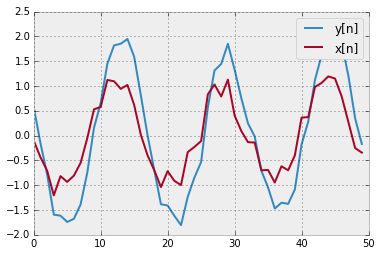

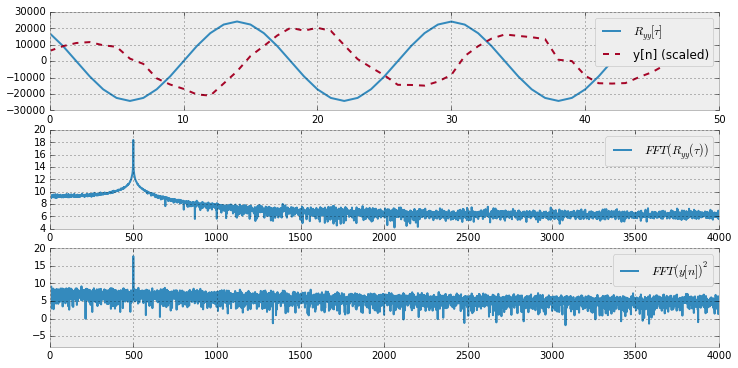

In [6]:
'''
    Generate signal (x[n]) and filter (y[n])
'''
N = 8192
Fs = 8000
x = generate_sine(500, 3, Fs, 30)
y = zeros(len(x)) 
for n in np.arange(0, len(x)): 
    y[n] = 0.5*y[n-1] + x[n]
fig = figure()
ax1 = fig.add_subplot(111) 
ax1.plot(y[200:250], label="y[n]") 
ax1.plot(x[200:250], label="x[n]") 
ax1.legend()

'''
    Compute Ryy[\tau] 
    Don't forget to plot FFT of autocorrelation or Syy[\tau] 
'''

# set up figures and axes
fig = figure(figsize=(12, 6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# calculate Ryy
Ryy = autocorr(y, 8192)
print len(Ryy)

# plot Ryy    
ax1.plot(Ryy[50:100], label=r"$R_{yy}[\tau]$")
ax1.plot(max(Ryy)/max(y)*y[50:100], '--', label="y[n] (scaled)") 
ax1.set_xlabel("Samples") 
ax1.legend()

# calculate FFT(Ryy) 
FFTsig = fft.rfft(Ryy, n=N)
FFTfreq = fft.rfftfreq(len(Ryy), d=1./Fs)

#plot FFT(Ryy)
ax2.plot(FFTfreq, log(abs(FFTsig)), label=r"$FFT(R_{yy}(\tau))$") 
print max(abs(FFTsig))
ax2.set_xlabel("Frequency (Hz)") 
ax2.legend()
ax3.set_ylim([-8, 20])


# calculate FFT(y[n])^2
FFTsig = fft.rfft(y, n=N)
FFTfreq = fft.rfftfreq(N, d=1./Fs)
print len(FFTsig) 

#plot FFT(y[n])^2
ax3.plot(FFTfreq, log(abs(FFTsig)**2), label=r"$FFT(y[n])^2$") 
print max(abs(FFTsig**2))
ax3.legend()
ax3.set_ylim([-8, 20])




## Conclusions 
The autocorrelation of a signal reduces non-periodic noise, and retains any periodic signals at the same period. The mathamatics predicted the removal of all non-periodic signals. Therefore, the removal of all noise, but this proved false. For a SNR of 30dB the original signal was unrecoverable. The fourier transform of an autocorrelated signal appears grossly simlar to the fourier transform of the original signal. The magnitude of the impulse in the fourier transform of $R_{yy}(\tau)$ was twice that of the corresponding impulse in the square of the fourier transform of $y[n]$. 